In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:3", "/gpu:4","/gpu:5"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-24 15:36:32.985954: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 15:36:32.998586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 15:36:33.011175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 15:36:33.014971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 15:36:33.025843: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2024-10-24 15:36:35.072266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-24 15:36:35.073700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0
2024-10-24 15:36:35.075035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c5:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 31, 
                transposed_midpoints_corrected[:, :, 1] * 31, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None, l1_reg=0.001, l2_reg=0.007):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(512, kernel_size=19, padding='same', activation='relu')(x_input)
        
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/13KFixed_Mixed_5_32by32_95indexFor19KernelNoNoise.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


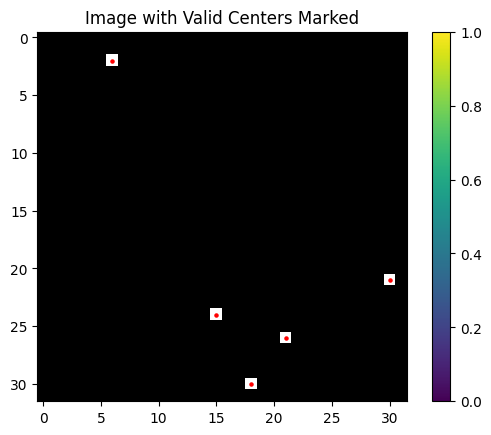

(<matplotlib.image.AxesImage at 0x7f9dd45cf2c0>, 4088)

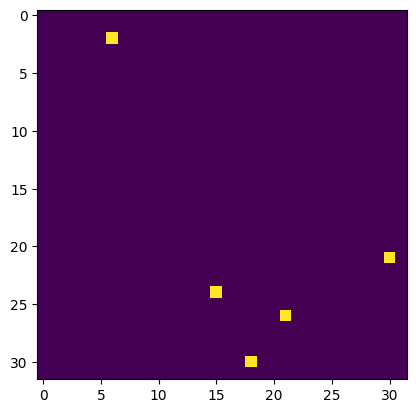

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

(<matplotlib.image.AxesImage at 0x7f2fb41ad250>, 10273)

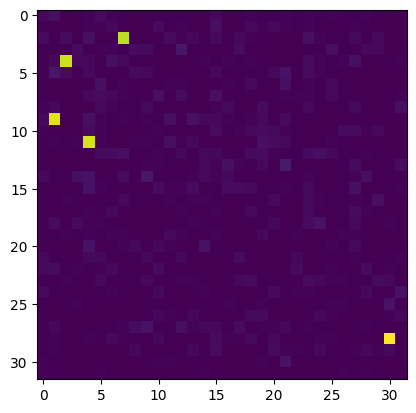

In [8]:
plt.imshow(images[l]),l

In [9]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1., 22.,  5.],
       [ 1.,  5., 11.],
       [ 1.,  1., 27.],
       [ 1., 14., 25.],
       [ 1., 29., 13.]], dtype=float32)

In [8]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [9]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [10]:
np.max(centers)

31.0

In [9]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (10400, 32, 32), Train Midpoints: (10400, 1, 5, 2)
Validation Images: (2600, 32, 32), Validation Midpoints: (2600, 1, 5, 2)


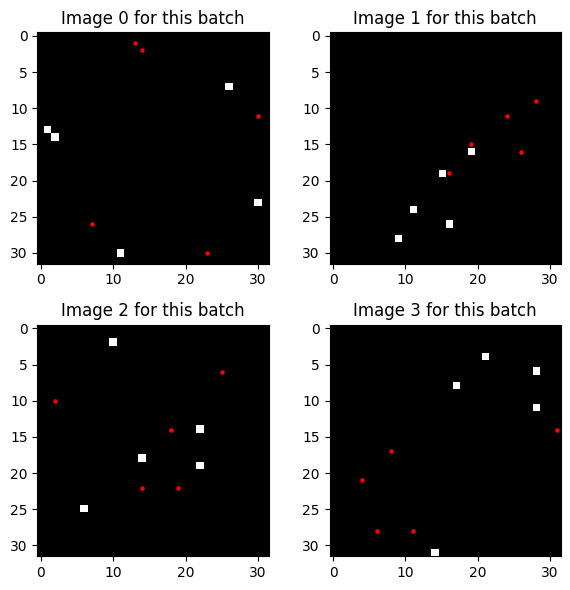

In [10]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [10]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=5e-6
)


In [11]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 512)    │       185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │     5,242,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,428,234 (20.71 MB)

 Trainable params: 5,428,234 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=2000,
    callbacks_list=[lr_scheduler]
)


Epoch 1/2000


2024-10-23 20:20:02.041632: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-23 20:20:03.918175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729714803.985210  386753 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714804.000593  386756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714804.005350  386754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714804.012768  386753 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714804.020272  386756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714804.027797  386754 gpu_timer.cc

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0788

2024-10-23 20:20:06.275664: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-23 20:20:06.275792: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
W0000 00:00:1729714806.286960  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714806.289280  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714806.292597  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714806.299495  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714806.312487  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0780

W0000 00:00:1729714806.702767  386758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714806.709650  386758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.171308  386752 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.184079  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.192797  386754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.201371  386749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.210582  386752 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.219184  386754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714807.228471  386749 gp

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - loss: 0.0771 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 2/2000


W0000 00:00:1729714809.653715  386744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714809.659480  386743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729714809.665200  386752 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0440

2024-10-23 20:20:10.649140: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0434 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 3/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0308 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 4/2000


2024-10-23 20:20:12.008718: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0265 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 5/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0246 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 6/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0233

2024-10-23 20:20:15.264491: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0233 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 7/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0224 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 8/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0213 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 9/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0206 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 10/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0198 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 11/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0193 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 12/2000


2024-10-23 20:20:21.293172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0185 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 13/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0180 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 14/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0179 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 15/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0172 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 16/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0170 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 17/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0164 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 18/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0163 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 19/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0156 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 20/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0153 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 

2024-10-23 20:20:32.049989: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0148 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 22/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0143

2024-10-23 20:20:33.965224: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0143 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 23/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0140 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 24/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0137 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 25/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0134 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 26/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0127 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 27/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0123 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 28/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0119 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 29/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0114 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 30/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0111
Epoch 30: ReduceLROnPlateau reducing learning rat

2024-10-23 20:20:58.832043: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0056 - val_loss: 0.0213 - learning_rate: 8.1000e-04
Epoch 45/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0056 - val_loss: 0.0227 - learning_rate: 8.1000e-04
Epoch 46/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0053

2024-10-23 20:21:02.242390: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0053 - val_loss: 0.0225 - learning_rate: 8.1000e-04
Epoch 47/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0051 - val_loss: 0.0230 - learning_rate: 8.1000e-04
Epoch 48/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0048 - val_loss: 0.0223 - learning_rate: 8.1000e-04
Epoch 49/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0045 - val_loss: 0.0220 - learning_rate: 8.1000e-04
Epoch 50/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0047 - val_loss: 0.0210 - learning_rate: 8.1000e-04
Epoch 51/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0044 - val_loss: 0.0212 - learning_rate: 8.1000e-04
Epoch 52/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0039 - val_loss: 0.0239 - learning_rate: 8.1000e-04
Epoch 53/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0037 - val_loss: 0.0219 - learning_rate: 8.1000e-04
Epoch 54/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0035 - val_loss: 0.021

2024-10-23 20:21:33.043322: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0015 - val_loss: 0.0216 - learning_rate: 6.5610e-04
Epoch 73/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0015 - val_loss: 0.0226 - learning_rate: 6.5610e-04
Epoch 74/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0014 - val_loss: 0.0230 - learning_rate: 6.5610e-04
Epoch 75/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0014 - val_loss: 0.0225 - learning_rate: 6.5610e-04
Epoch 76/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0012 - val_loss: 0.0227 - learning_rate: 6.5610e-04
Epoch 77/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0013 - val_loss: 0.0217 - learning_rate: 6.5610e-04
Epoch 78/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0011 - val_loss: 0.0218 - learning_rate: 6.5610e-04
Epoch 79/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0011 - val_loss: 0.0223 - learning_rate: 6.5610e-04
Epoch 80/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0011
Epoch 80: ReduceL

2024-10-23 20:21:49.736962: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.7975e-04 - val_loss: 0.0229 - learning_rate: 5.9049e-04
Epoch 88/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.6377e-04 - val_loss: 0.0229 - learning_rate: 5.9049e-04
Epoch 89/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.3943e-04 - val_loss: 0.0228 - learning_rate: 5.9049e-04
Epoch 90/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 7.9098e-04
Epoch 90: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.0060e-04 - val_loss: 0.0223 - learning_rate: 5.9049e-04
Epoch 91/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.8144e-04 - val_loss: 0.0232 - learning_rate: 5.3144e-04
Epoch 92/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.2906e-04 - val_loss: 0.0231 - learning_rate: 5.3144e-04
Epoch 93/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.0198e-04 - val_loss: 0.0237 - learning_rate: 5.3144e-04
Epoch 94/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:22:03.093870: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.7286e-04 - val_loss: 0.0227 - learning_rate: 5.3144e-04
Epoch 99/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.1397e-04 - val_loss: 0.0221 - learning_rate: 5.3144e-04
Epoch 100/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.0551e-04
Epoch 100: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.0528e-04 - val_loss: 0.0224 - learning_rate: 5.3144e-04
Epoch 101/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.9003e-04 - val_loss: 0.0236 - learning_rate: 4.7830e-04
Epoch 102/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.4687e-04 - val_loss: 0.0229 - learning_rate: 4.7830e-04
Epoch 103/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4148e-04 - val_loss: 0.0230 - learning_rate: 4.7830e-04
Epoch 104/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.2985e-04 - val_loss: 0.0229 - learning_rate: 4.7830e-04
Epoch 105/2000
11/11 ━━━━━━━━━━

2024-10-23 20:22:33.461684: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.5041e-04 - val_loss: 0.0233 - learning_rate: 3.8742e-04
Epoch 124/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4728e-04 - val_loss: 0.0235 - learning_rate: 3.8742e-04
Epoch 125/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4412e-04 - val_loss: 0.0234 - learning_rate: 3.8742e-04
Epoch 126/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.4144e-04 - val_loss: 0.0228 - learning_rate: 3.8742e-04
Epoch 127/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3043e-04 - val_loss: 0.0241 - learning_rate: 3.8742e-04
Epoch 128/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3325e-04 - val_loss: 0.0239 - learning_rate: 3.8742e-04
Epoch 129/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 3.2604e-04 - val_loss: 0.0229 - learning_rate: 3.8742e-04
Epoch 130/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.0966e-04
Epoch 130: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
11/11 ━━━━━━━━━━

2024-10-23 20:23:03.629939: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3602e-04 - val_loss: 0.0236 - learning_rate: 3.1381e-04
Epoch 150/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.3643e-04
Epoch 150: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3489e-04 - val_loss: 0.0233 - learning_rate: 3.1381e-04
Epoch 151/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2755e-04 - val_loss: 0.0250 - learning_rate: 2.8243e-04
Epoch 152/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2415e-04 - val_loss: 0.0226 - learning_rate: 2.8243e-04
Epoch 153/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2112e-04 - val_loss: 0.0232 - learning_rate: 2.8243e-04
Epoch 154/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.2158e-04 - val_loss: 0.0230 - learning_rate: 2.8243e-04
Epoch 155/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.1878e-04 - val_loss: 0.0244 - learning_rate: 2.8243e-04
Epoch 156/2000
11/11 ━━━━━━━━━━

2024-10-23 20:23:31.960395: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.8077e-04 - val_loss: 0.0237 - learning_rate: 2.2877e-04
Epoch 173/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7658e-04 - val_loss: 0.0244 - learning_rate: 2.2877e-04
Epoch 174/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.7172e-04

2024-10-23 20:23:34.420506: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.7187e-04 - val_loss: 0.0233 - learning_rate: 2.2877e-04
Epoch 175/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7568e-04 - val_loss: 0.0222 - learning_rate: 2.2877e-04
Epoch 176/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6930e-04 - val_loss: 0.0234 - learning_rate: 2.2877e-04
Epoch 177/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6956e-04 - val_loss: 0.0246 - learning_rate: 2.2877e-04
Epoch 178/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6848e-04 - val_loss: 0.0238 - learning_rate: 2.2877e-04
Epoch 179/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.6760e-04 - val_loss: 0.0239 - learning_rate: 2.2877e-04
Epoch 180/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.6508e-04
Epoch 180: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6471e-04 - val_loss: 0.0241 - learning_rate: 2.2877e-04
Epoch 181/2000
11/11 ━━━━━━━━━

2024-10-23 20:24:05.208809: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 200: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.4094e-04 - val_loss: 0.0244 - learning_rate: 1.8530e-04
Epoch 201/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.3985e-04 - val_loss: 0.0244 - learning_rate: 1.6677e-04
Epoch 202/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 1.3640e-04 - val_loss: 0.0240 - learning_rate: 1.6677e-04
Epoch 203/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.4211e-04 - val_loss: 0.0241 - learning_rate: 1.6677e-04
Epoch 204/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.3954e-04 - val_loss: 0.0235 - learning_rate: 1.6677e-04
Epoch 205/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.3763e-04 - val_loss: 0.0235 - learning_rate: 1.6677e-04
Epoch 206/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.3661e-04 - val_loss: 0.0244 - learning_rate: 1.6677e-04
Epoch 207/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.3465e-04 - val_loss: 0

2024-10-23 20:24:35.348575: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1918e-04 - val_loss: 0.0245 - learning_rate: 1.3509e-04
Epoch 227/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1635e-04 - val_loss: 0.0239 - learning_rate: 1.3509e-04
Epoch 228/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.1901e-04 - val_loss: 0.0246 - learning_rate: 1.3509e-04
Epoch 229/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.1484e-04 - val_loss: 0.0245 - learning_rate: 1.3509e-04
Epoch 230/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.1689e-04
Epoch 230: ReduceLROnPlateau reducing learning rate to 0.00012157666351413355.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1668e-04 - val_loss: 0.0242 - learning_rate: 1.3509e-04
Epoch 231/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1477e-04 - val_loss: 0.0250 - learning_rate: 1.2158e-04
Epoch 232/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 1.1632e-04 - val_loss: 0.0233 - learning_rate: 1.2158e-04
Epoch 233/2000
11/11 ━━━━━━━━

2024-10-23 20:25:06.200541: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 1.0742e-04 - val_loss: 0.0238 - learning_rate: 9.8477e-05
Epoch 252/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0569e-04 - val_loss: 0.0243 - learning_rate: 9.8477e-05
Epoch 253/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.0398e-04 - val_loss: 0.0246 - learning_rate: 9.8477e-05
Epoch 254/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.0235e-04 - val_loss: 0.0245 - learning_rate: 9.8477e-05
Epoch 255/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.0392e-04 - val_loss: 0.0250 - learning_rate: 9.8477e-05
Epoch 256/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0345e-04 - val_loss: 0.0241 - learning_rate: 9.8477e-05
Epoch 257/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0052e-04 - val_loss: 0.0240 - learning_rate: 9.8477e-05
Epoch 258/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 1.0400e-04 - val_loss: 0.0243 - learning_rate: 9.8477e-05
Epoch 259/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 20:25:36.404169: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 9.7171e-05 - val_loss: 0.0243 - learning_rate: 7.9766e-05
Epoch 278/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.5129e-05 - val_loss: 0.0252 - learning_rate: 7.9766e-05
Epoch 279/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.3824e-05 - val_loss: 0.0245 - learning_rate: 7.9766e-05
Epoch 280/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.3815e-05
Epoch 280: ReduceLROnPlateau reducing learning rate to 7.178980231401511e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.3586e-05 - val_loss: 0.0244 - learning_rate: 7.9766e-05
Epoch 281/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.4184e-05 - val_loss: 0.0241 - learning_rate: 7.1790e-05
Epoch 282/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 9.4239e-05 - val_loss: 0.0241 - learning_rate: 7.1790e-05
Epoch 283/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.2206e-05 - val_loss: 0.0239 - learning_rate: 7.1790e-05
Epoch 284/2000
11/11 ━━━━━━━━━━

2024-10-23 20:26:06.450721: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.7684e-05 - val_loss: 0.0251 - learning_rate: 5.8150e-05
Epoch 303/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.7890e-05 - val_loss: 0.0246 - learning_rate: 5.8150e-05
Epoch 304/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.4338e-05 - val_loss: 0.0236 - learning_rate: 5.8150e-05
Epoch 305/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.5658e-05 - val_loss: 0.0250 - learning_rate: 5.8150e-05
Epoch 306/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.5403e-05 - val_loss: 0.0233 - learning_rate: 5.8150e-05
Epoch 307/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.6041e-05 - val_loss: 0.0253 - learning_rate: 5.8150e-05
Epoch 308/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.4629e-05 - val_loss: 0.0235 - learning_rate: 5.8150e-05
Epoch 309/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.5587e-05 - val_loss: 0.0243 - learning_rate: 5.8150e-05
Epoch 310/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68

2024-10-23 20:26:36.557862: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.8068e-05 - val_loss: 0.0241 - learning_rate: 4.7101e-05
Epoch 328/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.2313e-05 - val_loss: 0.0248 - learning_rate: 4.7101e-05
Epoch 329/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.0673e-05 - val_loss: 0.0236 - learning_rate: 4.7101e-05
Epoch 330/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.0319e-05
Epoch 330: ReduceLROnPlateau reducing learning rate to 4.239116096869111e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.0059e-05 - val_loss: 0.0254 - learning_rate: 4.7101e-05
Epoch 331/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.0117e-05 - val_loss: 0.0243 - learning_rate: 4.2391e-05
Epoch 332/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.9437e-05 - val_loss: 0.0238 - learning_rate: 4.2391e-05
Epoch 333/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.0637e-05 - val_loss: 0.0245 - learning_rate: 4.2391e-05
Epoch 334/2000
11/11 ━━━━━━━━━━

2024-10-23 20:26:56.552650: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.8738e-05 - val_loss: 0.0238 - learning_rate: 3.8152e-05
Epoch 345/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.6960e-05 - val_loss: 0.0236 - learning_rate: 3.8152e-05
Epoch 346/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 7.7896e-05 - val_loss: 0.0248 - learning_rate: 3.8152e-05
Epoch 347/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.8248e-05 - val_loss: 0.0247 - learning_rate: 3.8152e-05
Epoch 348/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.9422e-05 - val_loss: 0.0238 - learning_rate: 3.8152e-05
Epoch 349/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.5960e-05 - val_loss: 0.0247 - learning_rate: 3.8152e-05
Epoch 350/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7.7895e-05
Epoch 350: ReduceLROnPlateau reducing learning rate to 3.4336842873017304e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.7530e-05 - val_loss: 0.0238 - learning_rate: 3.8152e-05
Epoch 351/2000
11/11 ━━━━━━━━━

2024-10-23 20:27:06.665309: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.6271e-05 - val_loss: 0.0244 - learning_rate: 3.4337e-05
Epoch 353/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.5628e-05 - val_loss: 0.0248 - learning_rate: 3.4337e-05
Epoch 354/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.5239e-05 - val_loss: 0.0251 - learning_rate: 3.4337e-05
Epoch 355/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.6827e-05 - val_loss: 0.0249 - learning_rate: 3.4337e-05
Epoch 356/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.5867e-05 - val_loss: 0.0250 - learning_rate: 3.4337e-05
Epoch 357/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.7300e-05 - val_loss: 0.0239 - learning_rate: 3.4337e-05
Epoch 358/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.3021e-05 - val_loss: 0.0245 - learning_rate: 3.4337e-05
Epoch 359/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.4733e-05 - val_loss: 0.0247 - learning_rate: 3.4337e-05
Epoch 360/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68

2024-10-23 20:27:37.397567: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.3982e-05 - val_loss: 0.0240 - learning_rate: 2.7813e-05
Epoch 378/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.0958e-05 - val_loss: 0.0248 - learning_rate: 2.7813e-05
Epoch 379/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.1556e-05 - val_loss: 0.0244 - learning_rate: 2.7813e-05
Epoch 380/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 7.3514e-05
Epoch 380: ReduceLROnPlateau reducing learning rate to 2.5031560107890984e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.3282e-05 - val_loss: 0.0246 - learning_rate: 2.7813e-05
Epoch 381/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.1491e-05 - val_loss: 0.0242 - learning_rate: 2.5032e-05
Epoch 382/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.1216e-05 - val_loss: 0.0245 - learning_rate: 2.5032e-05
Epoch 383/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.9516e-05 - val_loss: 0.0244 - learning_rate: 2.5032e-05
Epoch 384/2000
11/11 ━━━━━━━━━

2024-10-23 20:28:07.478123: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.0144e-05 - val_loss: 0.0241 - learning_rate: 2.0276e-05
Epoch 404/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.0790e-05 - val_loss: 0.0237 - learning_rate: 2.0276e-05
Epoch 405/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.9200e-05 - val_loss: 0.0237 - learning_rate: 2.0276e-05
Epoch 406/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.1509e-05 - val_loss: 0.0241 - learning_rate: 2.0276e-05
Epoch 407/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.9001e-05 - val_loss: 0.0249 - learning_rate: 2.0276e-05
Epoch 408/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.8598e-05 - val_loss: 0.0257 - learning_rate: 2.0276e-05
Epoch 409/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.0404e-05 - val_loss: 0.0254 - learning_rate: 2.0276e-05
Epoch 410/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.9365e-05
Epoch 410: ReduceLROnPlateau reducing learning rate to 1.8248007290821987e-05.
11/11 ━━━━━━━━━

2024-10-23 20:28:38.027184: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.7801e-05 - val_loss: 0.0236 - learning_rate: 1.6423e-05
Epoch 429/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.9078e-05 - val_loss: 0.0254 - learning_rate: 1.6423e-05
Epoch 430/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.5229e-05
Epoch 430: ReduceLROnPlateau reducing learning rate to 1.4780885430809576e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.5254e-05 - val_loss: 0.0239 - learning_rate: 1.6423e-05
Epoch 431/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.5758e-05 - val_loss: 0.0243 - learning_rate: 1.4781e-05
Epoch 432/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.6791e-05 - val_loss: 0.0227 - learning_rate: 1.4781e-05
Epoch 433/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.7190e-05 - val_loss: 0.0236 - learning_rate: 1.4781e-05
Epoch 434/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.3240e-05 - val_loss: 0.0255 - learning_rate: 1.4781e-05
Epoch 435/2000
11/11 ━━━━━━━━━

2024-10-23 20:29:08.162791: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.4460e-05 - val_loss: 0.0238 - learning_rate: 1.1973e-05
Epoch 454/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.6210e-05 - val_loss: 0.0248 - learning_rate: 1.1973e-05
Epoch 455/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.7076e-05 - val_loss: 0.0245 - learning_rate: 1.1973e-05
Epoch 456/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5598e-05 - val_loss: 0.0241 - learning_rate: 1.1973e-05
Epoch 457/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5601e-05 - val_loss: 0.0249 - learning_rate: 1.1973e-05
Epoch 458/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.4730e-05 - val_loss: 0.0243 - learning_rate: 1.1973e-05
Epoch 459/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5144e-05 - val_loss: 0.0250 - learning_rate: 1.1973e-05
Epoch 460/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.6618e-05
Epoch 460: ReduceLROnPlateau reducing learning rate to 1.077526558219688e-05.
11/11 ━━━━━━━━━━

2024-10-23 20:29:38.171115: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.6196e-05 - val_loss: 0.0254 - learning_rate: 9.6977e-06
Epoch 480/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.3210e-05
Epoch 480: ReduceLROnPlateau reducing learning rate to 8.727965268917615e-06.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3215e-05 - val_loss: 0.0234 - learning_rate: 9.6977e-06
Epoch 481/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.6246e-05 - val_loss: 0.0249 - learning_rate: 8.7280e-06
Epoch 482/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.4771e-05 - val_loss: 0.0252 - learning_rate: 8.7280e-06
Epoch 483/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.4045e-05 - val_loss: 0.0242 - learning_rate: 8.7280e-06
Epoch 484/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.7428e-05 - val_loss: 0.0238 - learning_rate: 8.7280e-06
Epoch 485/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.4088e-05 - val_loss: 0.0241 - learning_rate: 8.7280e-06
Epoch 486/2000
11/11 ━━━━━━━━━━

2024-10-23 20:30:08.761077: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.1993e-05 - val_loss: 0.0247 - learning_rate: 7.0697e-06
Epoch 506/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.2447e-05 - val_loss: 0.0247 - learning_rate: 7.0697e-06
Epoch 507/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3952e-05 - val_loss: 0.0251 - learning_rate: 7.0697e-06
Epoch 508/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.4835e-05 - val_loss: 0.0251 - learning_rate: 7.0697e-06
Epoch 509/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3367e-05 - val_loss: 0.0250 - learning_rate: 7.0697e-06
Epoch 510/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.1665e-05
Epoch 510: ReduceLROnPlateau reducing learning rate to 6.362686326610856e-06.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.1673e-05 - val_loss: 0.0240 - learning_rate: 7.0697e-06
Epoch 511/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.2027e-05 - val_loss: 0.0232 - learning_rate: 6.3627e-06
Epoch 512/2000
11/11 ━━━━━━━━━━

2024-10-23 20:30:38.901838: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.0528e-05
Epoch 530: ReduceLROnPlateau reducing learning rate to 5.15377605552203e-06.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.0644e-05 - val_loss: 0.0240 - learning_rate: 5.7264e-06
Epoch 531/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.1954e-05 - val_loss: 0.0232 - learning_rate: 5.1538e-06
Epoch 532/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.2098e-05 - val_loss: 0.0238 - learning_rate: 5.1538e-06
Epoch 533/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.0110e-05 - val_loss: 0.0256 - learning_rate: 5.1538e-06
Epoch 534/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.2545e-05 - val_loss: 0.0247 - learning_rate: 5.1538e-06
Epoch 535/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.3773e-05 - val_loss: 0.0234 - learning_rate: 5.1538e-06
Epoch 536/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.1710e-05 - val_loss: 0.0248 - learning_rate: 5.1538e-06
Epoch 537/2000
11/11 ━━━━━━━━━━━

2024-10-23 20:31:09.736001: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.2928e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 556/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0358e-05 - val_loss: 0.0233 - learning_rate: 5.0000e-06
Epoch 557/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.9827e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 558/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.2631e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 559/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.2929e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 560/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0072e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 561/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9748e-05 - val_loss: 0.0237 - learning_rate: 5.0000e-06
Epoch 562/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9331e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 563/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 20:31:40.288162: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.2058e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 582/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.1951e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 583/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.9580e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 584/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0544e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 585/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.0027e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 586/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 5.7910e-05 - val_loss: 0.0235 - learning_rate: 5.0000e-06
Epoch 587/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7495e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 588/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0351e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 589/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 20:32:10.301914: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9374e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 608/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.9966e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 609/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.9323e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 610/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.1523e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 611/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.8330e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 612/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7610e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 613/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.9836e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 614/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.7861e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 615/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 20:32:40.333391: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.0282e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 633/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9174e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 634/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.2249e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 635/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.8208e-05 - val_loss: 0.0230 - learning_rate: 5.0000e-06
Epoch 636/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.7491e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 637/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0540e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 638/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.7956e-05 - val_loss: 0.0237 - learning_rate: 5.0000e-06
Epoch 639/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0985e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 640/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:33:11.139467: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.7090e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 658/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.8270e-05 - val_loss: 0.0236 - learning_rate: 5.0000e-06
Epoch 659/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5861e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 660/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7611e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 661/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.7356e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 662/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7627e-05 - val_loss: 0.0233 - learning_rate: 5.0000e-06
Epoch 663/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7629e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 664/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.9042e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 665/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93

2024-10-23 20:33:41.164184: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.5408e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 684/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.6748e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 685/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.7881e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 686/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5998e-05 - val_loss: 0.0235 - learning_rate: 5.0000e-06
Epoch 687/2000


2024-10-23 20:33:45.762843: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5503e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 688/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.6215e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 689/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.6234e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 690/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5536e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 691/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7063e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 692/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5112e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 693/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6730e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 694/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7547e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 695/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 20:34:11.960588: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.4994e-05 - val_loss: 0.0265 - learning_rate: 5.0000e-06
Epoch 709/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6070e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 710/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7369e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 711/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.5614e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 712/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7392e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 713/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.6074e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 714/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6022e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 715/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.4989e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 716/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:34:42.749010: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4763e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 735/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.4002e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 736/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4579e-05 - val_loss: 0.0235 - learning_rate: 5.0000e-06
Epoch 737/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.3957e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 738/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.5103e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 739/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.4848e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 740/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3348e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 741/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.5296e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 742/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 20:35:13.484780: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.2456e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 761/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.3942e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 762/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.0786e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 763/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.3686e-05 - val_loss: 0.0234 - learning_rate: 5.0000e-06
Epoch 764/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.4631e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 765/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.2823e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 766/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3299e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 767/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.1084e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 768/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:35:43.503717: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.1685e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 787/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3927e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 788/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4078e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 789/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3175e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 790/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.3361e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 791/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.3826e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 792/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.1820e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 793/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.0852e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 794/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 20:36:13.545707: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.1086e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 812/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1981e-05 - val_loss: 0.0260 - learning_rate: 5.0000e-06
Epoch 813/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2631e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 814/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.0003e-05 - val_loss: 0.0233 - learning_rate: 5.0000e-06
Epoch 815/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0766e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 816/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.1077e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 817/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.2566e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 818/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0530e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 819/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:36:44.092050: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0092e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 837/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.0072e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 838/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1505e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 839/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9430e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 840/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0762e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 841/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.1024e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 842/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1311e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 843/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9572e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 844/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 20:37:14.100624: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.0303e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 863/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.8395e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 864/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0113e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 865/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9544e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 866/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.0315e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 867/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.0779e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 868/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9557e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 869/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.9135e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 870/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93

2024-10-23 20:37:44.228276: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7328e-05 - val_loss: 0.0237 - learning_rate: 5.0000e-06
Epoch 888/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.8489e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 889/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.8530e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 890/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.9477e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 891/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.8652e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 892/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5436e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 893/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.8322e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 894/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9397e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 895/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:38:14.722226: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 4.8804e-05 - val_loss: 0.0232 - learning_rate: 5.0000e-06
Epoch 913/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7488e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 914/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5710e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 915/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6207e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 916/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.8232e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 917/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7911e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 918/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9501e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 919/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6163e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 920/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 20:38:44.762282: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5768e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 939/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.8069e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 940/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7692e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 941/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.6117e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 942/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6486e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 943/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5394e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 944/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.5696e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 945/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.4390e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 946/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 20:39:15.742715: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 4.4551e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 964/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.5823e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 965/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.5536e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 966/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6062e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 967/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6248e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 968/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6862e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 969/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.4333e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 970/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.4351e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 971/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 20:39:46.546746: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.4054e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 990/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5514e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 991/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2986e-05 - val_loss: 0.0236 - learning_rate: 5.0000e-06
Epoch 992/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.6291e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 993/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.3990e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 994/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5068e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 995/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.4497e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 996/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.3872e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 997/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 20:40:16.559071: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.3854e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1016/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4380e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1017/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4264e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1018/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.4349e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1019/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3692e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1020/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.2657e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1021/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.3914e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1022/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3795e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1023/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:40:46.655235: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3527e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1041/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2260e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1042/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4695e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1043/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.4212e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1044/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.3052e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1045/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.3045e-05 - val_loss: 0.0237 - learning_rate: 5.0000e-06
Epoch 1046/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.1941e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1047/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.2062e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1048/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:41:17.421946: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1008e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1066/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2818e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1067/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2545e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1068/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2102e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 1069/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.3390e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1070/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2821e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1071/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0779e-05 - val_loss: 0.0260 - learning_rate: 5.0000e-06
Epoch 1072/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.2515e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1073/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:41:47.539487: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.0346e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1092/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.1213e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 1093/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2495e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1094/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1933e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1095/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1021e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1096/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2731e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 1097/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0702e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1098/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0820e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1099/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:42:18.291634: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.1375e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1117/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.1572e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 1118/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0639e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1119/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0636e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1120/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0634e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1121/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9790e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1122/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0565e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1123/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1892e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1124/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:42:48.470936: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.9610e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1143/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9327e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1144/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8496e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1145/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.8227e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1146/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.9387e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1147/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0311e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1148/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9564e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1149/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9007e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1150/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:43:19.044817: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.9655e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1168/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9342e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1169/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0219e-05 - val_loss: 0.0237 - learning_rate: 5.0000e-06
Epoch 1170/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9972e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1171/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0172e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1172/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.9516e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1173/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9713e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1174/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8895e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1175/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:43:49.239782: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6510e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1194/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0287e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1195/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8051e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1196/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.8340e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1197/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9146e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1198/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7956e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1199/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7937e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1200/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.8359e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1201/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:44:19.830870: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8827e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1219/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.6449e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1220/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6864e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1221/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.6499e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1222/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8403e-05 - val_loss: 0.0234 - learning_rate: 5.0000e-06
Epoch 1223/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.7755e-05 - val_loss: 0.0266 - learning_rate: 5.0000e-06
Epoch 1224/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.6355e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1225/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7832e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1226/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:44:49.834606: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.5705e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1244/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.7579e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1245/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.5799e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1246/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.7283e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1247/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6514e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 1248/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6048e-05 - val_loss: 0.0261 - learning_rate: 5.0000e-06
Epoch 1249/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.6123e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1250/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.5275e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1251/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:45:19.865147: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.6512e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1269/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.5232e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1270/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.7101e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1271/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.5385e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1272/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6094e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1273/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4605e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1274/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5290e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1275/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6878e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1276/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:45:50.588297: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6755e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1295/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6008e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1296/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5223e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1297/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.4734e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1298/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.5072e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 1299/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4905e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1300/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.6168e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1301/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.5154e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1302/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:46:20.627614: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.5360e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1320/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5296e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1321/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4969e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1322/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4037e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1323/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.3094e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1324/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4297e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1325/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.4252e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1326/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.5432e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1327/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:46:50.638069: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3670e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1345/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.4211e-05 - val_loss: 0.0234 - learning_rate: 5.0000e-06
Epoch 1346/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4062e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1347/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4170e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1348/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5252e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1349/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3648e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1350/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.3845e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1351/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4872e-05 - val_loss: 0.0234 - learning_rate: 5.0000e-06
Epoch 1352/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:47:20.667034: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.4554e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1371/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.3693e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1372/2000


2024-10-23 20:47:22.890012: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.2390e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1373/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.3207e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1374/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4093e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1375/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.3202e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 1376/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3593e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1377/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4689e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1378/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3824e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1379/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 3.2683e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1380/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:47:50.781818: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3541e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1396/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3221e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1397/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.2511e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1398/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3842e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1399/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2090e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1400/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4362e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1401/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.2550e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1402/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3572e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1403/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:48:21.240127: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 3.1409e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1418/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 3.3500e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1419/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3062e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1420/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.3825e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1421/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1930e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1422/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3252e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1423/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3805e-05 - val_loss: 0.0260 - learning_rate: 5.0000e-06
Epoch 1424/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 3.2078e-05 - val_loss: 0.0260 - learning_rate: 5.0000e-06
Epoch 1425/2000
11/11 ━━━━━━━━━━━━━━━━

2024-10-23 20:48:51.667523: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1168e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1442/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1973e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 1443/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.2286e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1444/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2442e-05 - val_loss: 0.0233 - learning_rate: 5.0000e-06
Epoch 1445/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.1301e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1446/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3203e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1447/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.1319e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1448/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 3.2028e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1449/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:49:21.818197: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1676e-05 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 1467/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2031e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1468/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1388e-05 - val_loss: 0.0261 - learning_rate: 5.0000e-06
Epoch 1469/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0983e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1470/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1123e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1471/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1090e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1472/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.1583e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1473/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.2573e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1474/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:49:51.989494: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.2371e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1493/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9924e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1494/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1864e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1495/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0551e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1496/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9606e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1497/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1253e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1498/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.1123e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1499/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0135e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1500/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:50:22.459031: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 3.0182e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1517/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 2.9614e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1518/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 2.9700e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1519/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 3.1665e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1520/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 3.0815e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1521/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 2.8786e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1522/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.0488e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1523/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 3.1327e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1524/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:50:53.145367: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9146e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1542/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0177e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1543/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.9987e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1544/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.9626e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1545/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.9728e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1546/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.9285e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1547/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.9464e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1548/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0151e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1549/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:51:23.684203: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.8515e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1568/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.9482e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1569/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.9563e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1570/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.9762e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1571/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.9234e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1572/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9494e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1573/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.9406e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1574/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.0091e-05 - val_loss: 0.0261 - learning_rate: 5.0000e-06
Epoch 1575/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:51:53.903192: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8073e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1592/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.9869e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 1593/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8467e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1594/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8634e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1595/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8606e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1596/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 2.8056e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1597/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.8593e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1598/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.9302e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1599/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:52:24.703616: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7481e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1617/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.8432e-05 - val_loss: 0.0262 - learning_rate: 5.0000e-06
Epoch 1618/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8837e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1619/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7960e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1620/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7572e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1621/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7947e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1622/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.9373e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1623/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7045e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1624/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:52:55.270418: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8447e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1642/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7042e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1643/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7239e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1644/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7818e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1645/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7893e-05 - val_loss: 0.0241 - learning_rate: 5.0000e-06
Epoch 1646/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8514e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1647/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8337e-05 - val_loss: 0.0259 - learning_rate: 5.0000e-06
Epoch 1648/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7493e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1649/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:53:25.481126: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7587e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1667/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7514e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1668/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7342e-05 - val_loss: 0.0236 - learning_rate: 5.0000e-06
Epoch 1669/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7432e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1670/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7327e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1671/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7606e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1672/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8061e-05 - val_loss: 0.0262 - learning_rate: 5.0000e-06
Epoch 1673/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8118e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1674/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:53:56.026248: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8156e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1692/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7724e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1693/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6114e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1694/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.6510e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1695/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6360e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1696/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5912e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1697/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5804e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1698/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7680e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1699/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:54:26.568174: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6261e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1717/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7526e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1718/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6243e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 1719/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7241e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1720/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6722e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1721/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5345e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1722/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5780e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1723/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.6080e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1724/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:54:56.761884: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6562e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1742/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6807e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1743/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5176e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1744/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6051e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1745/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6786e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1746/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5606e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1747/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5341e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1748/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6517e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1749/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:55:27.107768: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5790e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1767/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7024e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1768/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5209e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1769/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5004e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1770/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.5298e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1771/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6393e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1772/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6085e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1773/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5193e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1774/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:55:57.130154: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5174e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1793/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4472e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1794/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 2.5789e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1795/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5019e-05 - val_loss: 0.0235 - learning_rate: 5.0000e-06
Epoch 1796/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5346e-05 - val_loss: 0.0239 - learning_rate: 5.0000e-06
Epoch 1797/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5855e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1798/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.5325e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1799/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4791e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1800/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:56:27.406273: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5150e-05 - val_loss: 0.0268 - learning_rate: 5.0000e-06
Epoch 1817/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.4460e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1818/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4975e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1819/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5326e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1820/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 2.5363e-05 - val_loss: 0.0234 - learning_rate: 5.0000e-06
Epoch 1821/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5558e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1822/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5473e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1823/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4882e-05 - val_loss: 0.0236 - learning_rate: 5.0000e-06
Epoch 1824/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:56:57.627830: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4458e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1842/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5460e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1843/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5629e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1844/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.4068e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1845/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4794e-05 - val_loss: 0.0265 - learning_rate: 5.0000e-06
Epoch 1846/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4985e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1847/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4339e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1848/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4797e-05 - val_loss: 0.0267 - learning_rate: 5.0000e-06
Epoch 1849/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:57:27.775668: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3418e-05 - val_loss: 0.0240 - learning_rate: 5.0000e-06
Epoch 1867/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3696e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1868/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3544e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1869/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5246e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1870/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3591e-05 - val_loss: 0.0247 - learning_rate: 5.0000e-06
Epoch 1871/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3255e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1872/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.4372e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1873/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4034e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1874/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:57:57.981786: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3608e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1893/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2745e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1894/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 2.3069e-05 - val_loss: 0.0244 - learning_rate: 5.0000e-06
Epoch 1895/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4603e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1896/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3300e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1897/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3874e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1898/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.4778e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1899/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2936e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1900/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:58:28.184848: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3636e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1918/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2838e-05 - val_loss: 0.0242 - learning_rate: 5.0000e-06
Epoch 1919/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3198e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1920/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 2.2993e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1921/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3270e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1922/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4420e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1923/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3500e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1924/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3628e-05 - val_loss: 0.0246 - learning_rate: 5.0000e-06
Epoch 1925/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:58:58.238052: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2530e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1943/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2940e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1944/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2612e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1945/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4659e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1946/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 2.3048e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1947/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3095e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1948/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3493e-05 - val_loss: 0.0256 - learning_rate: 5.0000e-06
Epoch 1949/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2979e-05 - val_loss: 0.0255 - learning_rate: 5.0000e-06
Epoch 1950/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 20:59:28.316048: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2238e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1968/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2149e-05 - val_loss: 0.0253 - learning_rate: 5.0000e-06
Epoch 1969/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2728e-05 - val_loss: 0.0245 - learning_rate: 5.0000e-06
Epoch 1970/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2801e-05 - val_loss: 0.0251 - learning_rate: 5.0000e-06
Epoch 1971/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2078e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1972/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2927e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1973/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2111e-05 - val_loss: 0.0258 - learning_rate: 5.0000e-06
Epoch 1974/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2627e-05 - val_loss: 0.0254 - learning_rate: 5.0000e-06
Epoch 1975/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 20:59:58.448287: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2453e-05 - val_loss: 0.0248 - learning_rate: 5.0000e-06
Epoch 1993/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2219e-05 - val_loss: 0.0243 - learning_rate: 5.0000e-06
Epoch 1994/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2180e-05 - val_loss: 0.0250 - learning_rate: 5.0000e-06
Epoch 1995/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.1523e-05 - val_loss: 0.0252 - learning_rate: 5.0000e-06
Epoch 1996/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2420e-05 - val_loss: 0.0265 - learning_rate: 5.0000e-06
Epoch 1997/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2312e-05 - val_loss: 0.0238 - learning_rate: 5.0000e-06
Epoch 1998/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2473e-05 - val_loss: 0.0249 - learning_rate: 5.0000e-06
Epoch 1999/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2544e-05 - val_loss: 0.0261 - learning_rate: 5.0000e-06
Epoch 2000/2000
11/11 ━━━━━━━━━━━━━━━━━━

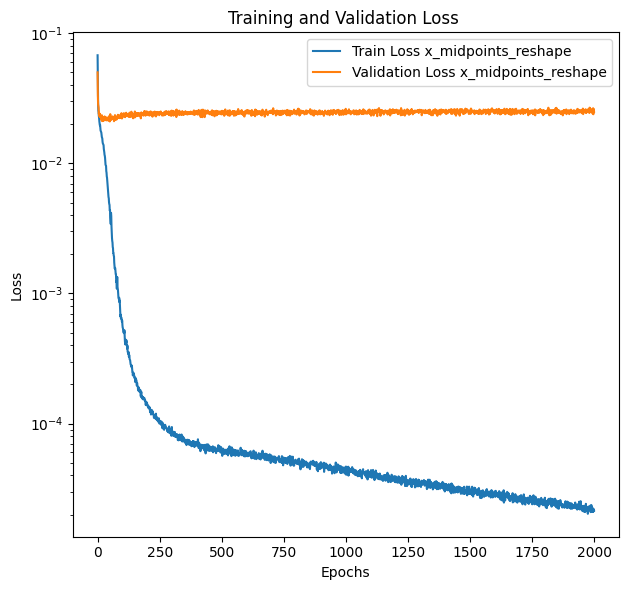

In [13]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# model_builder.model.save("/home/da886/Analysis/13KFixed_Mixed_5_32by32_95indexFor19KernelNoNoise.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Define the function for visualizing midpoints
# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Create the validation dataset
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# # val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# # inputs,targets = next(iter(train_dataset))
# # outputs = model_builder.model.predict(inputs)
# # # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions =model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
val_dataset = val_dataset.batch(800)
# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
for i, (data_batch, midpoints_batch) in enumerate(val_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


2024-10-23 21:10:15.477756: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (200, 32, 32)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


W0000 00:00:1729717816.560441  386758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.560863  386737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.561087  386720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.562130  386758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.562438  386737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.562841  386720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.563223  386758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.563797  386737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729717816.564093  386720 gp

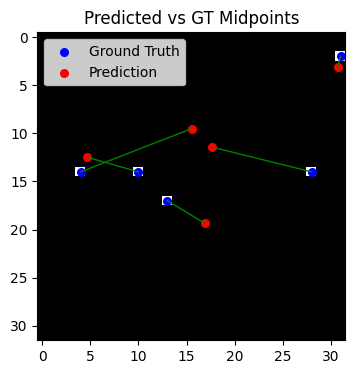

In [42]:
index_to_visualize = np.random.randint(0, len(all_images))
# Visualize the results for the first sample (you can change the index to visualize others)
visualize_midpoints_with_gt(all_images[index_to_visualize ], all_true_midpoints[index_to_visualize ]*np.max(centers), all_pred_midpoints[index_to_visualize ]*np.max(centers))


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [20]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 13, 2), (9600, 1, 13, 2))

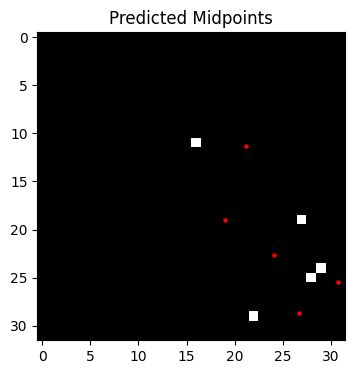

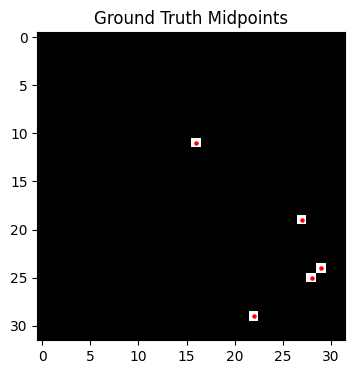

In [23]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [38]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(8.843155e-06, 30.997658)

In [39]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

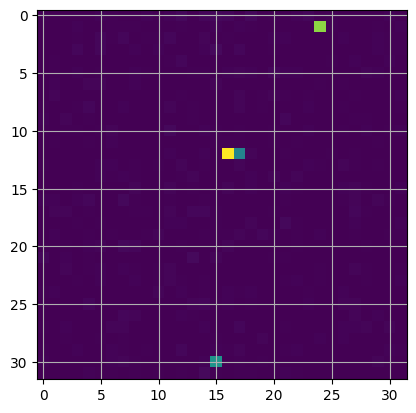

In [44]:
plt.imshow(images[2],)
plt.grid(True)

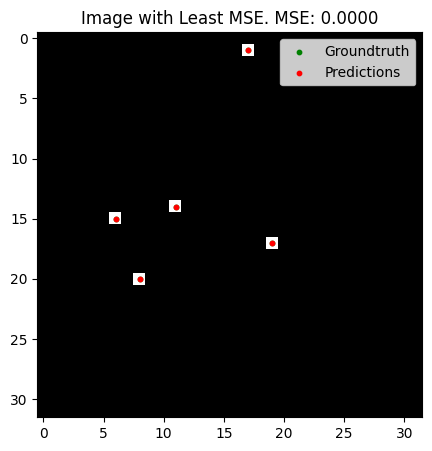

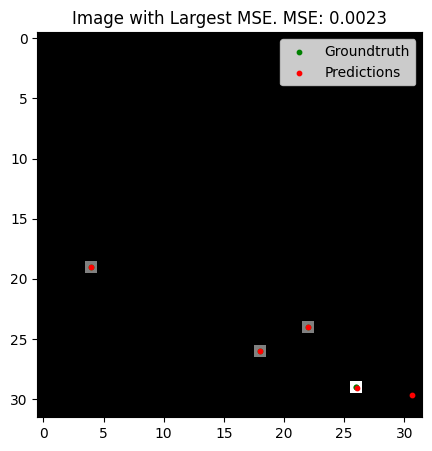

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266